In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(parallel)
library(introdataviz)


In [2]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/meta_data_2024-01-16_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')
meta_data<-meta_data %>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 1 Day 90','Flu Year 2 Day 0','Flu Year 2 Day 90'))
donors<-names(table(meta_data$subject.subjectGuid)[table(meta_data$subject.subjectGuid)==4])
meta_data<-meta_data %>% filter(subject.subjectGuid %in% donors)

In [3]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [4]:
colnames(meta)<-c('donor','CMV','Sex','cohort.cohortGuid')

In [5]:
CV_Res_FILES<-list.files(path = "01A_CV_result/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [6]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [7]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [8]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [224]:
gene="HBB"
celltype="Core_naive_CD4_T_cell"
mean_expression_list<-mclapply(donors,function(i){  

print(i)
meta_data_donor<-meta_data %>% filter(subject.subjectGuid == i)
    
df_list<-mclapply(seq(from = 1, to = 4, by = 1),function(x){
df<-read.csv(paste0('01A_Mean_Expression_by_Celltype_and_Sample/',pull(meta_data_donor['pbmc_sample_id'])[x],'_AIFI_L3.csv'),row.names = 1,check.names = FALSE)
df<-as.data.frame(df)
colnames(df)<-paste0(pull(meta_data_donor['sample.visitName'])[x],':',colnames(df))   
return(df[c(gene),])
},mc.cores=4)

df_all<-do.call(cbind,df_list)
colnames(df_all)<-gsub(" ",'_',colnames(df_all))
df_all<-as.data.frame(t(df_all[, grepl(celltype, names(df_all), fixed = TRUE)]))
df_all$donor<-i
df_all$timepoint_celltype<-rownames(df_all)
rownames(df_all)<-NULL
return(df_all)
},mc.cores=30)

In [225]:
mean_df<-do.call(rbind,mean_expression_list)%>% 
  separate(timepoint_celltype, into = c("Flu_Year_Day", "Cell_Type"), sep = ":")

In [226]:
colnames(mean_df)[1]<-"mean_expression"

In [227]:
mean_df$cohorts<-substr(mean_df$donor,1,3)


`geom_smooth()` using formula = 'y ~ x'


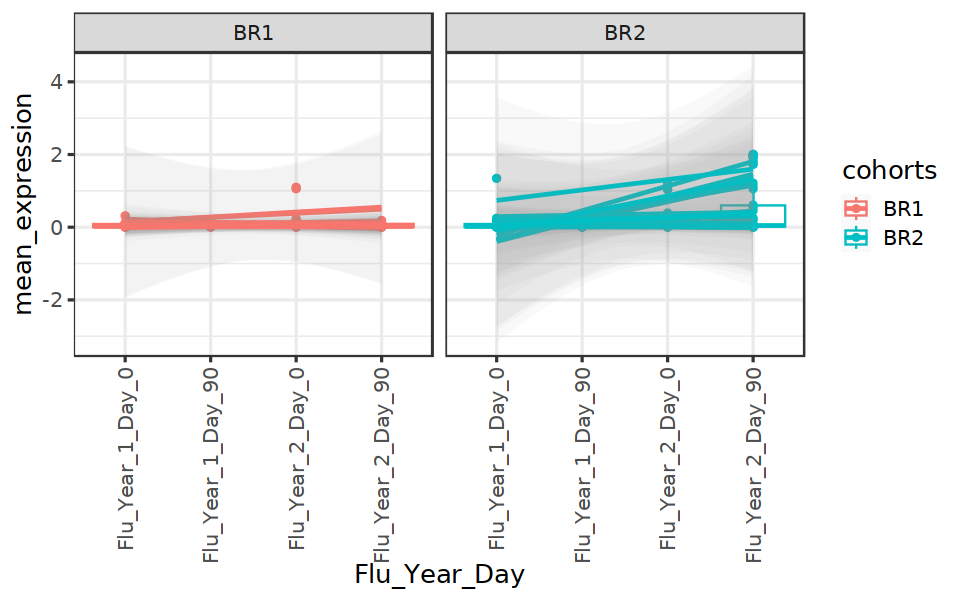

In [228]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(mean_df, aes(x=Flu_Year_Day, y=mean_expression, color=cohorts))  + 
  geom_boxplot() + geom_point()+
      stat_smooth(aes(group = donor), method = "lm",alpha=0.05, se = TRUE) +facet_wrap(~cohorts)+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

`geom_smooth()` using formula = 'y ~ x'


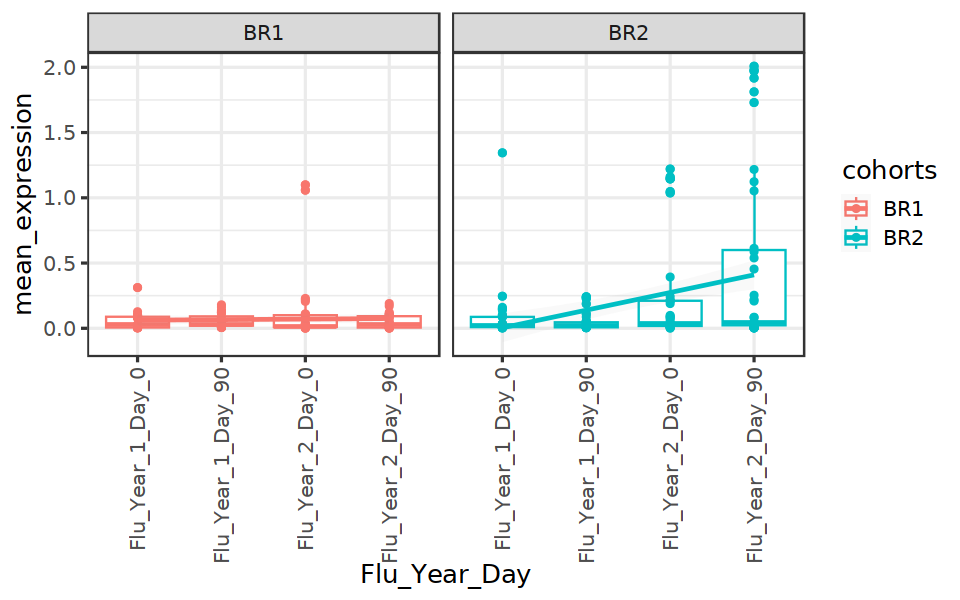

In [229]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(mean_df, aes(x=Flu_Year_Day, y=mean_expression, color=cohorts))  + 
  geom_boxplot() + geom_point()+
      stat_smooth(aes(group = cohorts), method = "lm",alpha=0.05, se = TRUE) +facet_wrap(~cohorts)+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


In [223]:
meta_data %>% filter(file.batchID=='B153')

X.1,X,lastUpdated,sample.id,sample.bridgingControl,sample.sampleKitGuid,sample.visitName,sample.visitDetails,sample.drawDate,sample.daysSinceFirstVisit,⋯,pbmc_sample_id,Sample_ID,file.name.downloaded,file.path,Sample_Draw_date,Covid_Dose_1,Covid_Dose_2,Covid_exlcusion,CMV.IgG.Serology.Result.Interpretation,BMI
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
780,672,2024-01-09T08:38:58.711Z,246dfba9-be83-4658-9d80-22946d020781,false,KT02575,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2021-12-01T00:00:00Z,454,⋯,PB02575-001,NA,B153-P2_PB02575-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/a495993e-bbac-4f15-ad24-ae89786b04c6/B153-P2_PB02575-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2021-12-20,2020-12-26,2021-01-16,no,Positive,>25-30BMI
787,679,2024-01-09T08:38:58.711Z,0b4b4e01-0ab9-4a6b-b681-f522f4048e62,false,KT02583,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2021-12-01T00:00:00Z,523,⋯,PB02583-001,NA,B153-P2_PB02583-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/0bacd40d-697f-42e2-be9b-ab69643ada56/B153-P2_PB02583-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2021-12-22,2021-02-27,2021-03-20,no,Positive,>25-30BMI
804,696,2024-01-09T08:38:58.711Z,977a7059-46dc-4cde-9216-8a0ddb7c5b6f,false,KT03067,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,468,⋯,PB03067-001,NA,B153-P2_PB03067-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/b2f358d8-bf04-4bbb-b9c0-e1a2ec330772/B153-P2_PB03067-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2022-01-11,2021-04-13,2021-05-11,no,Negative,>30BMI
810,702,2024-01-09T08:38:58.711Z,b89a0a75-d328-442a-80fa-baef662a4bdd,false,KT03073,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,471,⋯,PB03073-001,NA,B153-P2_PB03073-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/ac2b9192-a2f9-4c62-b40a-dfe2c8406b34/B153-P2_PB03073-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2022-01-13,2021-04-18,2021-05-16,no,Positive,<25-BMI
815,707,2024-01-09T08:38:58.711Z,d67749cb-0027-42ac-926b-49cc80a2e629,false,KT03078,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,512,⋯,PB03078-001,NA,B153-P2_PB03078-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/da0dfd43-9696-4fcf-af09-7f396472da03/B153-P2_PB03078-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2022-01-19,2021-04-01,2021-04-29,no,Negative,<25-BMI
818,710,2024-01-09T08:38:58.711Z,6d7c0c3e-ba68-4c54-b510-6266cf5068b9,false,KT03081,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,481,⋯,PB03081-001,NA,B153-P2_PB03081-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/38cfeb25-1fd7-4f94-99d1-df8440808cdc/B153-P2_PB03081-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2022-01-24,2021-04-01,2021-04-21,no,Negative,<25-BMI
821,713,2024-01-09T08:38:58.711Z,a0911652-b41d-4b20-a097-e56b9f3a5a88,false,KT03084,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,473,⋯,PB03084-001,NA,B153-P1_PB03084-001_2023-04-05T23:37:26.235502246Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/3416e6fc-ed29-48cc-9ef1-7ab3ca65b1ed/B153-P1_PB03084-001_2023-04-05T23:37:26.235502246Z_labeled.h5,2022-01-25,2021-04-08,2021-05-07,no,Positive,>25-30BMI
826,718,2024-01-09T08:38:58.711Z,5ce035d1-7239-4aa9-936f-6666e50c773f,false,KT03090,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,477,⋯,PB03090-001,NA,B153-P1_PB03090-001_2023-04-05T23:37:26.235502246Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/478d296b-8ca3-42b8-822f-8e7a80ff5fa9/B153-P1_PB03090-001_2023-04-05T23:37:26.235502246Z_labeled.h5,2022-01-28,2021-03-16,2021-04-13,no,Positive,>25-30BMI
828,720,2024-01-09T08:38:58.711Z,4db17b27-6f6e-4019-96fb-b1f0b8b9d6ef,false,KT03092,Flu Year 2 Day 90,N/A - Flu-Series Timepoin

In [221]:
colnames(meta_data)

[1] "X.1"                                   
 [2] "X"                                     
 [3] "lastUpdated"                           
 [4] "sample.id"                             
 [5] "sample.bridgingControl"                
 [6] "sample.sampleKitGuid"                  
 [7] "sample.visitName"                      
 [8] "sample.visitDetails"                   
 [9] "sample.drawDate"                       
[10] "sample.daysSinceFirstVisit"            
[11] "file.id"                               
[12] "file.name"                             
[13] "file.batchID"                          
[14] "file.panel"                            
[15] "file.pool"                             
[16] "file.fileType"                         
[17] "file.majorVersion"                     
[18] "subject.id"                            
[19] "subject.biologicalSex"                 
[20] "subject.birthYear"                     
[21] "subject.ethnicity"                     
[22] "subject.partnerCode"                   
[23] "subject.race"                          
[24] "subject.subjectGuid"                   
[25] "cohort.cohortGuid"                     
[26] "sample.diseaseStatesRecordedAtVisit"   
[27] "pbmc_sample_id"                        
[28] "Sample_ID"                             
[29] "file.name.downloaded"                  
[30] "file.path"                             
[31] "Sample_Draw_date"                      
[32] "Covid_Dose_1"                          
[33] "Covid_Dose_2"                          
[34] "Covid_exlcusion"                       
[35] "CMV.IgG.Serology.Result.Interpretation"
[36] "BMI"

In [232]:
meta_data_donor<-meta_data %>% filter(subject.subjectGuid == 'BR2031')
meta_data_donor

X.1,X,lastUpdated,sample.id,sample.bridgingControl,sample.sampleKitGuid,sample.visitName,sample.visitDetails,sample.drawDate,sample.daysSinceFirstVisit,⋯,pbmc_sample_id,Sample_ID,file.name.downloaded,file.path,Sample_Draw_date,Covid_Dose_1,Covid_Dose_2,Covid_exlcusion,CMV.IgG.Serology.Result.Interpretation,BMI
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
74,74,2023-11-18T02:03:08.347Z,4635f969-25e6-4e72-9bff-5b0897780587,false,KT00563,Flu Year 1 Day 0,N/A - Flu-Series Timepoint Only,2020-10-01T00:00:00Z,64,⋯,PB00563-01,NA,B056-P2_PB00563-01_2021-06-09T18:00:29.080476056Z_labeled.h5,/home//jupyter/reference_generating_new/cache/1b11c6fa-5b29-45e3-a482-7b06a7857331/B056-P2_PB00563-01_2021-06-09T18:00:29.080476056Z_labeled.h5,2020-10-28,2021-04-01,2021-04-29,no,Negative,<25-BMI
393,285,2024-01-09T08:38:58.711Z,2ac926f7-7a57-40d2-a660-7af78e488f45,false,KT01445,Flu Year 1 Day 90,N/A - Flu-Series Timepoint Only,2021-01-01T00:00:00Z,155,⋯,PB01445-01,NA,B056-P1_PB01445-01_2021-06-09T17:59:56.368250998Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/4a50dc07-62b1-44e9-9d16-081f20357bad/B056-P1_PB01445-01_2021-06-09T17:59:56.368250998Z_labeled.h5,2021-01-27,2021-04-01,2021-04-29,no,Negative,<25-BMI
705,597,2024-01-09T08:38:58.711Z,8e2c6f90-d2cb-4184-b108-7cc0de389e52,false,KT02498,Flu Year 2 Day 0,N/A - Flu-Series Timepoint Only,2021-10-01T00:00:00Z,420,⋯,PB02498-001,NA,B106-P2_PB02498-001_2022-02-15T03:48:38.437970481Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/bcd3232e-4f56-44ca-83d6-9ecb339ade93/B106-P2_PB02498-001_2022-02-15T03:48:38.437970481Z_labeled.h5,2021-10-19,2021-04-01,2021-04-29,no,Negative,<25-BMI
815,707,2024-01-09T08:38:58.711Z,d67749cb-0027-42ac-926b-49cc80a2e629,false,KT03078,Flu Year 2 Day 90,N/A - Flu-Series Timepoint Only,2022-01-01T00:00:00Z,512,⋯,PB03078-001,NA,B153-P2_PB03078-001_2023-04-05T23:38:10.563072758Z_labeled.h5,/home/jupyter/BRI_Analysis/scRNA/cache/da0dfd43-9696-4fcf-af09-7f396472da03/B153-P2_PB03078-001_2023-04-05T23:38:10.563072758Z_labeled.h5,2022-01-19,2021-04-01,2021-04-29,no,Negative,<25-BMI


In [231]:
mean_df %>% arrange(desc(mean_expression))

mean_expression,donor,Flu_Year_Day,Cell_Type,cohorts
<dbl>,<chr>,<chr>,<chr>,<chr>
2.0085016,BR2031,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
1.9796023,BR2040,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
1.9702585,BR2037,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
1.9172977,BR2036,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
1.8117985,BR2033,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
1.7298083,BR2018,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
1.3446556,BR2040,Flu_Year_1_Day_0,Core_naive_CD4_T_cell,BR2
1.2204051,BR2052,Flu_Year_2_Day_0,Core_naive_CD4_T_cell,BR2
1.2173169,BR2052,Flu_Year_2_Day_90,Core_naive_CD4_T_cell,BR2
